In [317]:
from bs4 import BeautifulSoup
import time
import pandas as pd
import requests
import sqlite3
from random import randint
from time import sleep

In [ ]:
#Function to get main url Tiki
def get_url(url):
    request = requests.get(url)
    soup = BeautifulSoup(request.text, 'html.parser')
    return soup

In [ ]:
#Finding tag for categories 
link = get_url('https://tiki.vn/')
link.find_all('a', {'class' : 'MenuItem__MenuLink-sc-181aa19-1 fKvTQu'})

In [226]:
conn = sqlite3.connect('Tiki_main.db')
cur = conn.cursor()

In [212]:
#Creating a table named Categories
def create_table():
    query = '''
    CREATE TABLE IF NOT EXISTS categories 
    (id INTEGER PRIMARY KEY AUTOINCREMENT,
    name VARCHAR(256),
    url TEXT,
    parent_id INTEGER
    )'''
    try:
        conn.execute(query)
        conn.commit()
    except Exception as err:
        print('Error', err)

create_table()

In [ ]:
class Category():
    def __init__(self, name, url, parent_id = None, cat_id = None):
        self.cat_id = cat_id
        self.name = name
        self.url = url
        self.parent_id = parent_id
        
    
    def __repr__(self):
        return f"ID: {self.cat_id}, Name: {self.name}, URL: {self.url}, Parent: {self.parent_id}"
    
    def save_into_db(self):
        query = '''
        INSERT INTO categories
        (name, url, parent_id)
        VALUES (?,?,?)'''
        
        value = (self.name, self.url, self.parent_id)
        
        try:
            cur.execute(query, value)
            self.cat_id = cur.lastrowid
            conn.commit()
        except Exception as err:
            print("Error")

In [ ]:
#Function to get main categories
def main(save_db = False):
    soup = get_url('https://tiki.vn/')
    
    result = []
    
    for a in soup.find_all('a', {'class': 'MenuItem__MenuLink-sc-181aa19-1 fKvTQu'}):
        name = a.find('span', {'class': 'text'}).text
        url = a['href']
        main_cat = Category(name, url)
        
        if save_db:
            main_cat.save_into_db()
        result.append(main_cat)
        
    return result

In [ ]:
main_categories = main(save_db = True)

In [ ]:
print(len(main_categories))
#16 main categories

In [ ]:
import re

def sub_categories(parent_category, save_db = False):
    parent_url = parent_category.url
    result = []
    
    try:
        soup = get_url(parent_url)
        div_children = soup.find_all('div', {'class': 'list-group-item is-child'})
        
        for div in div_children:
            name = div.a.text.strip()
            
            name = re.sub('\s{2,}','',name)
            
            sub_url = 'https://tiki.vn/' + div.a['href']
            cat = Category(name, sub_url, parent_category.cat_id)
            
            if save_db:
                cat.save_into_db()
                
            result.append(cat)
                
    except Exception as err:
        print("Error with children categories", err)
    
    return result

In [ ]:
def get_all(categories):
    if len(categories) == 0:
        return
    
    for item in categories:
        children_categories = sub_categories(item, save_db = True)
        print(children_categories)
        get_all(children_categories)

In [ ]:
get_all(main_categories)

In [213]:
def product_table():
    query = '''
    CREATE TABLE IF NOT EXISTS product
    (Product_id INTEGER PRIMARY KEY AUTOINCREMENT,
    Title VARCHAR(256),
    Brand VARCHAR(256),
    Original INTEGER,
    Discounted SMALLINT,
    Final INTEGER,
    Link TEXT,
    Cat_id INTEGER)'''
    #Tom suggested I search up how to do one to many relationships in sqlite python...
    # FOREIGN KEY (Cat_id) REFERENCES categories (id)
    
    try:
        conn.execute(query)
        conn.commit()
    except Exception as err:
        print('Error', err)

In [223]:
product_table()

In [222]:
cur.execute('DROP table product')

In [177]:
#Damn OOP feels good
class Product():
    def __init__(self, title, brand, original, discounted, final, link, cat_id = None, product_id = None): 
        self.title = title
        self.brand = brand
        self.original = original
        self.discounted = discounted
        self.final = final
        self.link = link 
        self.product_id = product_id 
        self.cat_id = cat_id
    
    def __repr__(self):
        return f'''
        Title: {self.title}, 
        Brand: {self.brand}, 
        Original: {self.original}, 
        Discounted: {self.discounted}, 
        Final: {self.final}, 
        Link: {self.link}'''
    
    
    def save_into_db(self):
        query = '''
        INSERT INTO product
        (Title, Brand, Original, Discounted, Final, Link, cat_id)
        VALUES (?,?,?,?,?,?,?);'''
        #7 parameters 
        value = (self.title,self.brand, self.original, self.discounted, self.final, self.link, self.cat_id)
        
        #cur.lastrowid autoincrement for Primary key 
        try:
            cur.execute(query,value)
            self.product_id = cur.lastrowid
            conn.commit()
            
        except Exception as err:
            print("Error", err)

In [118]:
def get_all_url_id():
    sub_categories = pd.read_sql('''
    SELECT a.url, a.id
    FROM categories AS a
    LEFT JOIN categories as b ON a.id = b.parent_id
    WHERE b.id IS NULL
    ORDER BY a.name ASC''', conn)
    
    return sub_categories
#Don't use distinct, otherwise you won't get back the id value for table referencing 

In [209]:
sub_categories = get_all_url_id()

In [224]:
def get_product(save_db = False):
    result = []
    try:
        #Shortcoming: I didn't take into consideration that some products don't have discount and,thus, no final price
        #But I was too deep in ... 
        
        for product in products:
            title = product['data-title']
            brand = product['data-brand']
            original = product.find('span', {'class': 'price-regular'}).text.replace('đ','').replace('.','')
            #try..except
            discounted = product.find('span', {'class': 'sale-tag sale-tag-square'}).text.replace('%','')
            #try..except 
            final = product['data-price']
            link = 'tiki.vn' + product.a['href']
            
            #See below for reference on iloc
            #The sub_categories['id'] is a np.interger, whereas our table only supports int type...
            #We need to change to int to avoid something call a BLOB type. Search google! 
            
            item = Product(title, brand, original, discounted, final, link, int(sub_categories['id'].iloc[pages]))
            if save_db:
                item.save_into_db()
            result.append(item)
    except Exception as err:
        print('F', err)
    
    return result 

In [64]:
#Testing to see if we can use .iloc to get url. See below for refrence on iloc. 
r = requests.get(sub_categories['url'].iloc[0])
soup = BeautifulSoup(r.text, 'html.parser')
product = soup.find('div', {'class':'product-item'})

In [66]:
print(len(sub_categories))

2680


In [168]:
print(type(sub_categories['id'].iloc[0]))
#Checking type for sub_categories['id']#

<class 'numpy.int64'>


In [100]:
str(sub_categories['url'].iloc[0])

'https://tiki.vn//3d/c23742?src=c.1883.hamburger_menu_fly_out_banner'

In [232]:
sub_categories = get_all_url_id()

In [233]:
sub_categories

,url,id
0,https://tiki.vn//3d/c23742?src=c.1883.hamburge...,887
1,https://tiki.vn//access-point-diem-truy-cap/c4...,314
2,https://tiki.vn//access/c14884?src=c.8322.hamb...,2827
3,https://tiki.vn//action-adventure/c142?src=c.8...,2849
4,https://tiki.vn//action-adventure/c11017?src=c...,2793
...,...,...
2675,https://tiki.vn//o-cam-dien/c2021?src=c.1883.h...,557
2676,https://tiki.vn//o-khoa-vali/c8389?src=c.914.h...,2125
2677,https://tiki.vn//o-khoa/c2154?src=c.1883.hambu...,562
2678,https://tiki.vn//o-dia-quang/c28908?src=c.1846...,280


In [ ]:
# Pages in range len(sub_categories) will return the link one by one 
for pages in range(0, len(sub_categories)):
    for i in range(1, 7000):
        #The nested loop runs first, hence we can switch page here... 
        #Got scammed... The max page is 23, even for a category with "300k products"
        try:
            # The .iloc returns the actual value of the table. See above for refrence
            
            r = requests.get(str(sub_categories['url'].iloc[pages]) + '&page=' +str(i))
            soup = BeautifulSoup(r.text, 'html.parser')
            products = soup.find_all('div', {'class':'product-item'})
        except:
            continue
        # if we can't find any products, we skip the rest of the function and move onto the next i value...
        
        if len(products) == 0:
            break
        # if len of products == 0, that means we're at the end... of the road. Break nested loop, and move to next
        # url 
            
        result = get_product(save_db = True)
        sleep(randint(2,6))   
    
        #randint, courtesy of Jack Cao! 

In [291]:
import seaborn as sns
import matplotlib.pyplot as plt

In [228]:
#3247 categories 
pd.read_sql('SELECT name FROM categories', conn)

,name
0,Điện Thoại - Máy Tính Bảng
1,Điện Tử - Điện Lạnh
2,Phụ Kiện - Thiết Bị Số
3,Laptop - Thiết bị IT
4,Máy Ảnh - Quay Phim
...,...
3242,GYM(28)
3243,Yoga(3)
3244,Ca nhạc - Phim - Kịch(2)
3245,Studio - Chụp ảnh(47)


In [298]:
#Listing price/categories 

price_categories = pd.read_sql('''
SELECT c.name, p.final
FROM categories AS c
LEFT JOIN product AS p on c.id = p.cat_id
WHERE p.final IS NOT NULL
LIMIT 100''', conn)

price_categories

,name,Final
0,3D(5161),97000
1,3D(5161),43000
2,3D(5161),69000
3,3D(5161),49000
4,3D(5161),139000
...,...,...
95,Action & Adventure(158),112800
96,Action & Adventure(158),238700
97,Action & Adventure(158),164500
98,Action & Adventure(158),544500


In [311]:
#Which categories have the most expensive item 
most_expensive_categories = pd.read_sql('''
SELECT p.title, p.final, p.brand
FROM product AS p
WHERE title like 'bộ phát%'
''', conn)

most_expensive_categories

,Title,Final,Brand
0,Bộ Phát Wifi Mesh TP-Link Deco M5 AC1300 MU-MI...,3950000,TP-Link
1,Bộ Phát Wifi Mesh Băng Tần Kép Asus MAP-AC1750...,7850000,Asus
2,Bộ Phát Wifi Mesh D-Link COVR-C1203 MU-MIMO - ...,3350000,D-Link
3,Bộ Phát Wifi Mesh TP-Link Deco M4 AC1200 MU-MI...,2145000,TP-Link
4,Bộ Phát Wifi Mesh Băng Tần Kép TP-Link Deco E4...,1639000,TP-Link
...,...,...,...
93,Bộ phát Wifi trong nhà ENGENIUS EWS357AP Hàng ...,9450000,Engenius
94,Bộ phát Wifi trong nhà ENGENIUS EWS511AP Hàng ...,2450000,Engenius
95,Bộ phát Wifi trong nhà ENGENIUS EWS550AP Hàng ...,3920000,Engenius
96,Bộ phát Wifi trong nhà ENGENIUS EWS360AP Hàng ...,4850000,Engenius


<AxesSubplot:xlabel='Title', ylabel='Final'>

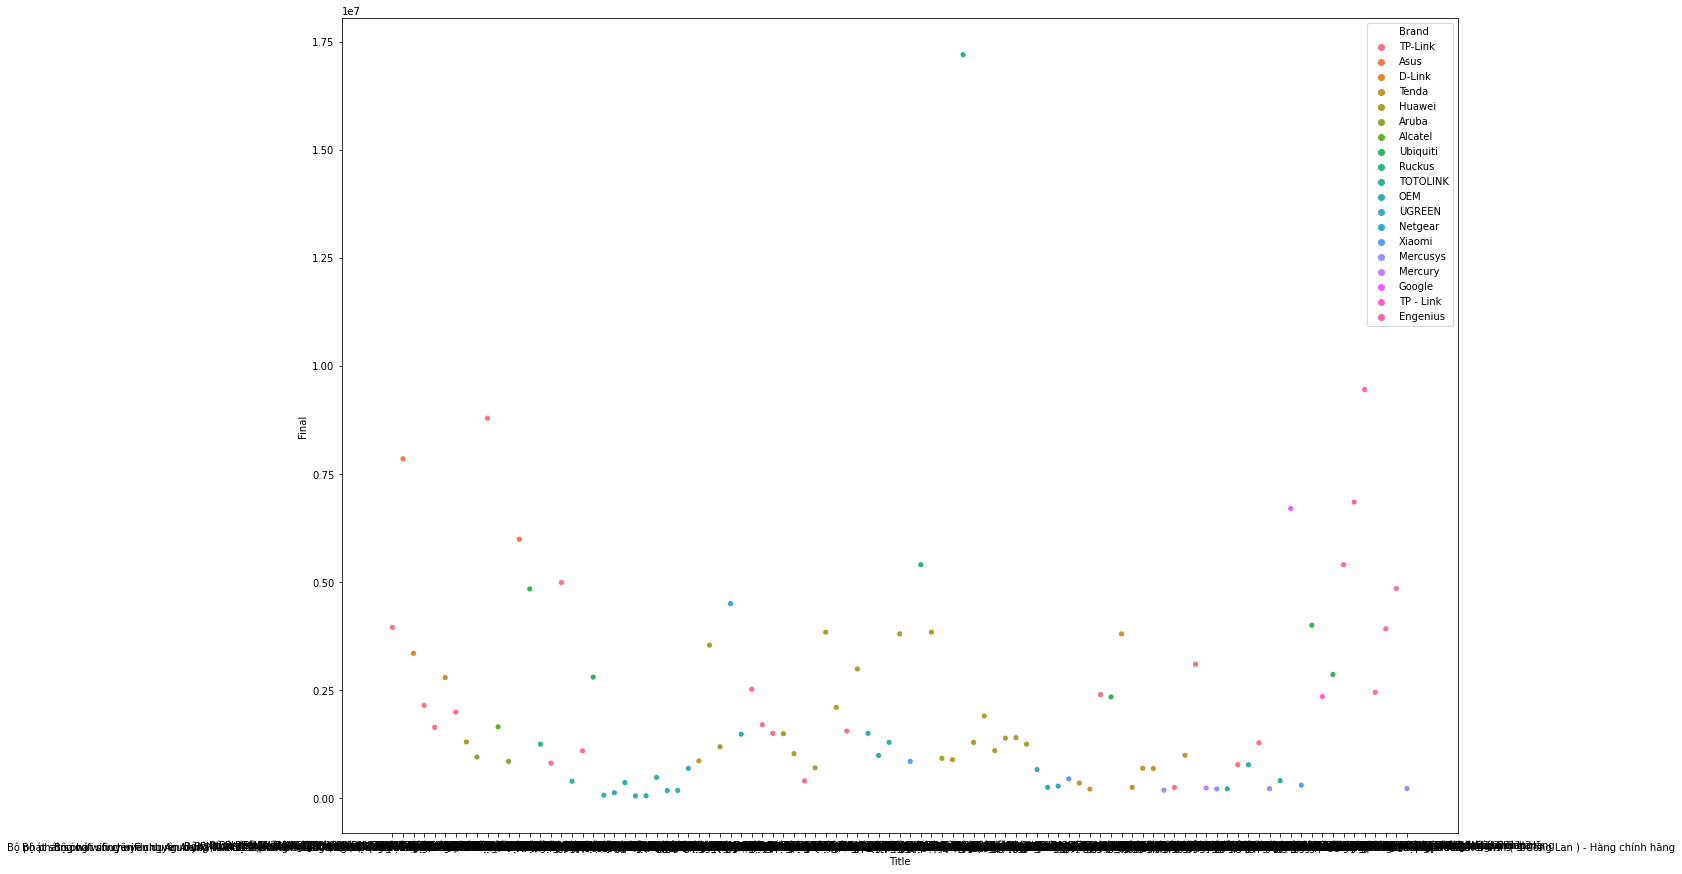

In [315]:
plt.figure(figsize = (20,15))
sns.scatterplot(y = 'Final', x = 'Title', hue = 'Brand', data = most_expensive_categories)

<AxesSubplot:xlabel='name', ylabel='Final'>

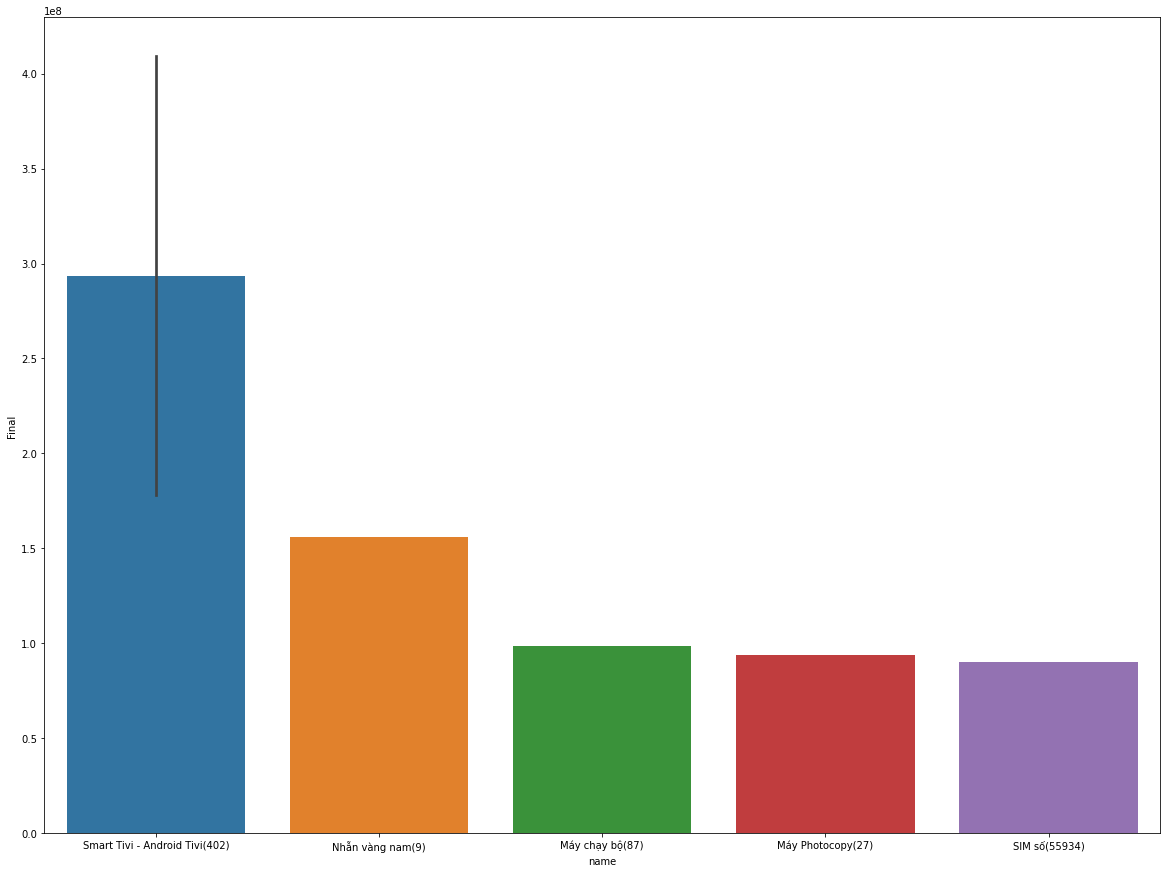

In [295]:
plt.figure(figsize=(20,15))
sns.barplot(y = 'Final', x = 'name', data = most_expensive_categories)

In [282]:
#WHICH categories have the highest discount
highest_discount_categories = pd.read_sql('''
SELECT c.name, p.discounted 
FROM categories AS c
LEFT JOIN product as p ON c.id = p.cat_id
WHERE p.discounted IS NOT NULL
ORDER BY p.discounted ASC
LIMIT 10''', conn)

#Know where I'm getting my girl earrings  
highest_discount_categories

,name,Discounted
0,Bông tai bạc nữ(999),-98
1,Dụng cụ sửa chữa khác(5753),-97
2,Tai Nghe Bluetooth Nhét Tai(1291),-97
3,Kính mát nữ(2810),-96
4,Pin Sạc Dự Phòng Di Động(1169),-96
5,Adapter Sạc - Củ Sạc Thường(1125),-95
6,Quần lót nữ(2951),-95
7,"Quần, Váy bé gái(650)",-95
8,Dây Cáp Sạc Micro USB(771),-94
9,Máy rửa mặt(146),-94


In [284]:
#Which categories have the lowest discount
lowest_discount_categories = pd.read_sql('''
SELECT c.name, p.discounted 
FROM categories AS c
LEFT JOIN product as p ON c.id = p.cat_id
WHERE p.discounted IS NOT NULL
ORDER BY p.discounted DESC
LIMIT 10''', conn)

#So a lot is at -1% discount... 
lowest_discount_categories

,name,Discounted
0,Access Point - Điểm Truy Cập(71),-1
1,Access Point - Điểm Truy Cập(71),-1
2,Adapter Sạc - Cáp Sạc Cho Thiết Bị Đeo(51),-1
3,Adapter Sạc - Củ Sạc Thường(1125),-1
4,Adapter Sạc - Củ Sạc Thường(1125),-1
5,Adapter Sạc - Củ Sạc Thường(1125),-1
6,Adapter Sạc - Củ Sạc Xe Hơi(288),-1
7,Adapter Sạc Laptop(1023),-1
8,Adapter Sạc Laptop(1023),-1
9,Adapter Sạc Laptop(1023),-1
